# Download data at https://drive.google.com/drive/folders/1yfH-t6juCpK2fZg78HjmVXzl-qbtj3LI?usp=sharing

# Read the data

In [53]:
import pyreadr
import geopandas as gpd
import numpy as np

In [62]:
strata = gpd.read_file('extracted_points_wgs84.gpkg')['Stratum'].to_numpy()
group_1c = (strata == 1)
group_ge2c = (strata == 2)
group_0c = (strata > 2)

In [5]:
count_1c = np.sum(group_1c.astype(int))
print(count_1c)
count_ge2c = np.sum(group_ge2c.astype(int))
print(count_ge2c)
count_0c = np.sum(group_0c.astype(int))
print(count_0c)
print(count_1c+count_ge2c+count_0c)
print(strata.shape)

2599
2599
46780
51978
(51978,)


In [5]:
bands = ['blue', 'green', 'nir', 'red', 'swir1', 'swir2', 'thermal']
merged_agg_data_1c = np.full((count_1c*7,156), np.nan, dtype=np.double) 
merged_agg_data_ge2c = np.full((count_ge2c*7,156), np.nan, dtype=np.double) 
merged_agg_data_0c = np.full((count_0c*7,156), np.nan, dtype=np.double) 
merged_ARCO_data_1c = np.empty((count_1c*7,156), dtype=np.double) 
merged_ARCO_data_ge2c = np.empty((count_ge2c*7,156), dtype=np.double) 
merged_ARCO_data_0c = np.empty((count_0c*7,156), dtype=np.double) 

data = pyreadr.read_r('clear.rds')[None].to_numpy()
clear_1c = data[group_1c]
clear_ge2c = data[group_ge2c]
clear_0c = data[group_0c]
mask_1c = (clear_1c == 250)
mask_ge2c = (clear_ge2c == 250)
mask_0c = (clear_0c == 250)
np.save('clear_1c', clear_1c)
np.save('clear_ge2c', clear_ge2c)
np.save('clear_0c', clear_0c)


for i, band in enumerate(bands):
    data = pyreadr.read_r(f'{band}.rds')[None].to_numpy()
    data_1c = data[group_1c]
    data_ge2c = data[group_ge2c]
    data_0c = data[group_0c]
    
    merged_agg_data_1c[i*count_1c:(i+1)*count_1c,:][mask_1c] = data_1c[mask_1c]
    merged_agg_data_ge2c[i*count_ge2c:(i+1)*count_ge2c,:][mask_ge2c] = data_ge2c[mask_ge2c]
    merged_agg_data_0c[i*count_0c:(i+1)*count_0c,:][mask_0c] = data_0c[mask_0c]
    
    merged_ARCO_data_1c[i*count_1c:(i+1)*count_1c,:] = data_1c
    merged_ARCO_data_ge2c[i*count_ge2c:(i+1)*count_ge2c,:] = data_ge2c
    merged_ARCO_data_0c[i*count_0c:(i+1)*count_0c,:] = data_0c
    
np.save('merged_agg_data_1c', merged_agg_data_1c)
np.save('merged_agg_data_ge2c', merged_agg_data_ge2c)
np.save('merged_agg_data_0c', merged_agg_data_0c)
np.save('merged_ARCO_data_1c', merged_ARCO_data_1c)
np.save('merged_ARCO_data_ge2c', merged_ARCO_data_ge2c)
np.save('merged_ARCO_data_0c', merged_ARCO_data_0c)


# Compare performance of time series reconstruction methods

In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18,9))

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

In [2]:
def add_nan_elements(A, fraction_of_nan):
    B = np.copy(A)
    non_nan_indices = np.where(~np.isnan(A))
    total_non_nan_elements = len(non_nan_indices[0])
    nan_elements_count = int(total_non_nan_elements * fraction_of_nan)
    chosen_indices = np.random.choice(total_non_nan_elements, nan_elements_count, replace=False)
    nan_indices = (non_nan_indices[0][chosen_indices], non_nan_indices[1][chosen_indices], non_nan_indices[2][chosen_indices])
    B[nan_indices] = np.nan
    return B

In [3]:
def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

In [4]:
def compute_CVRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        mean_ref = np.abs(np.mean(np.array(data_ref[mask_cmp], dtype=np.double)))
        CVRMSE = RMSE / mean_ref
        rerr.append(CVRMSE)
    return rerr

In [8]:
def compute_NDVI(data_ref_nir, data_ref_red):
    data_ref = (data_ref_nir/250. - data_ref_red/250.) / (data_ref_nir/250. + data_ref_red/250.)
    data_ref[data_ref == np.infty] = np.nan
    data_ref[data_ref == -np.infty] = np.nan
    data_ref = data_ref * 125. + 125.
    data_ref[data_ref < 0.] = 0.
    data_ref[data_ref > 250.] = 250.
    return data_ref

In [9]:
merged_agg_data_1c = np.load('merged_agg_data_1c.npy')
merged_agg_data_ge2c = np.load('merged_agg_data_ge2c.npy')
merged_agg_data_0c = np.load('merged_agg_data_0c.npy')
ndvi_stable = np.load('ndvi_stable.npy')
ndvi_unstable = np.load('ndvi_unstable.npy')

In [10]:
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_methods = 4
n_bands = 7
n_iter = 3
CVRMSE_mat = np.zeros((len(nan_fraction_vec), n_methods, n_bands+2, n_iter), np.double)
tot_nan_fracs = np.zeros((len(nan_fraction_vec), n_bands+2, n_iter), np.double)

use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
n_t_tot_1c = merged_agg_data_1c.shape[0]
n_t_tot_0c = merged_agg_data_0c.shape[0]
n_t_tot_ge2c = merged_agg_data_ge2c.shape[0]
n_t_1c = int(n_t_tot_1c/n_bands)
n_t_0c = int(n_t_tot_0c/n_bands)
n_t_ge2c = int(n_t_tot_ge2c/n_bands)
n_s = merged_agg_data_1c.shape[1]

for it in range(n_iter):
    for k in range(n_bands+2):
    # for k in [n_bands,]:
        if k >= n_bands:
            data_tmp = np.concatenate((merged_agg_data_1c[3*n_t_1c:(3+1)*n_t_1c,:], \
                                       merged_agg_data_ge2c[3*n_t_ge2c:(3+1)*n_t_ge2c,:], \
                                       merged_agg_data_0c[3*n_t_0c:(3+1)*n_t_0c,:]), axis=0)
            n_t = data_tmp.shape[0]        
            data_ref_red = np.zeros((1, n_t, n_s))
            data_ref_red[0,:,:] = data_tmp.copy()
            data_tmp = np.concatenate((merged_agg_data_1c[2*n_t_1c:(2+1)*n_t_1c,:], \
                                       merged_agg_data_ge2c[2*n_t_ge2c:(2+1)*n_t_ge2c,:], \
                                       merged_agg_data_0c[2*n_t_0c:(2+1)*n_t_0c,:]), axis=0)
            n_t = data_tmp.shape[0]        
            data_ref_nir = np.zeros((1, n_t, n_s))
            data_ref_nir[0,:,:] = data_tmp.copy()
            
            data_ref = compute_NDVI(data_ref_nir, data_ref_red)
            
            
        else:
            data_tmp = np.concatenate((merged_agg_data_1c[k*n_t_1c:(k+1)*n_t_1c,:], \
                                       merged_agg_data_ge2c[k*n_t_ge2c:(k+1)*n_t_ge2c,:], \
                                       merged_agg_data_0c[k*n_t_0c:(k+1)*n_t_0c,:]), axis=0)
            n_t = data_tmp.shape[0]        
            data_ref = np.zeros((1, n_t, n_s))
            data_ref[0,:,:] = data_tmp.copy()
            

        for i, nan_fraction in enumerate(nan_fraction_vec):
            
            if k == n_bands + 1:
                
                data_red = add_nan_elements(data_ref_red, nan_fraction)
                data_nir = data_ref_nir.copy()
                data_nir[np.isnan(data_red)] = np.nan
                tot_nan_fracs[i,k,it] = np.sum(np.isnan(data_red).astype(int))/data_red.size

                wv_f_LI = 1-np.arange(1,n_s)/n_s
                wv_p_LI = wv_f_LI.copy()[::-1]
                sircleTransformer_LI = process.SircleTransformer(wv_0=1, wv_f=wv_f_LI, wv_p=wv_p_LI, backend="dense", use_mask=True, return_den=True)
                out_LI_red, _ = sircleTransformer_LI._run(data_red)
                out_LI_nir, _ = sircleTransformer_LI._run(data_nir)
                out_LI = compute_NDVI(out_LI_nir, out_LI_red)

                wv_p_MR = get_SWAG_weights(130, 0, 6, n_s)[1:][::-1]
                wv_f_MR = get_SWAG_weights(130, 0, 6, n_s)[1:]*use_future
                sircleTransformer_MR = process.SircleTransformer(wv_0=1, wv_f=wv_f_MR, wv_p=wv_p_MR, backend="dense", use_mask=True, return_den=True)
                out_MR_red, _ = sircleTransformer_MR._run(data_red)
                out_MR_nir, _ = sircleTransformer_MR._run(data_nir)
                out_MR = compute_NDVI(out_MR_nir, out_MR_red)
                

                wv_0_SG = coef[w_l]
                wv_f_SG = coef[w_l+1:]
                wv_p_SG = coef[0:w_l]
                sircleTransformer_SG = process.SircleTransformer(wv_0=wv_0_SG, wv_f=wv_f_SG, wv_p=wv_p_SG, backend="sparse", use_mask=False)
                out_SG_red = sircleTransformer_SG._run(out_MR_red)
                out_SG_nir = sircleTransformer_SG._run(out_MR_nir)
                out_SG = compute_NDVI(out_SG_nir, out_SG_red)

                wv_p_prod = get_SWAG_weights(46, 45, 6, n_s)[1:][::-1]
                wv_f_prod = get_SWAG_weights(46, 45, 6, n_s)[1:]*use_future
                sircleTransformer_prod = process.SircleTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
                out_prod_red, _ = sircleTransformer_prod._run(data_red)
                out_prod_nir, _ = sircleTransformer_prod._run(data_nir)
                out_prod = compute_NDVI(out_prod_nir, out_prod_red)

                wv_0_SG2 = coef[w_l]
                wv_f_SG2 = coef[w_l+1:]
                wv_p_SG2 = coef[0:w_l]
                sircleTransformer_SG2 = process.SircleTransformer(wv_0=wv_0_SG2, wv_f=wv_f_SG2, wv_p=wv_p_SG2, backend="sparse", use_mask=False)
                out_SG2_red = sircleTransformer_SG2._run(out_prod_red)
                out_SG2_nir = sircleTransformer_SG2._run(out_prod_nir)
                out_SG2 = compute_NDVI(out_SG2_nir, out_SG2_red)

                out_vec = (out_LI, out_SG, out_SG2, out_prod)
                CVRMSE_mat[i,:,k,it] = compute_CVRMSE(out_vec, data_red, data_ref)
                
                
            else:
                    
            
                data = add_nan_elements(data_ref, nan_fraction)
                tot_nan_fracs[i,k,it] = np.sum(np.isnan(data).astype(int))/data.size

                wv_f_LI = 1-np.arange(1,n_s)/n_s
                wv_p_LI = wv_f_LI.copy()[::-1]
                sircleTransformer_LI = process.SircleTransformer(wv_0=1, wv_f=wv_f_LI, wv_p=wv_p_LI, backend="dense", use_mask=True, return_den=True)
                out_LI, mask_LI = sircleTransformer_LI._run(data)

                wv_p_MR = get_SWAG_weights(130, 0, 6, n_s)[1:][::-1]
                wv_f_MR = get_SWAG_weights(130, 0, 6, n_s)[1:]*use_future
                sircleTransformer_MR = process.SircleTransformer(wv_0=1, wv_f=wv_f_MR, wv_p=wv_p_MR, backend="dense", use_mask=True, return_den=True)
                out_MR, mask_MR = sircleTransformer_MR._run(data)

                wv_0_SG = coef[w_l]
                wv_f_SG = coef[w_l+1:]
                wv_p_SG = coef[0:w_l]
                sircleTransformer_SG = process.SircleTransformer(wv_0=wv_0_SG, wv_f=wv_f_SG, wv_p=wv_p_SG, backend="sparse", use_mask=False)
                out_SG = sircleTransformer_SG._run(out_MR)

                wv_p_prod = get_SWAG_weights(46, 45, 6, n_s)[1:][::-1]
                wv_f_prod = get_SWAG_weights(46, 45, 6, n_s)[1:]*use_future
                sircleTransformer_prod = process.SircleTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
                out_prod, mask_prod = sircleTransformer_prod._run(data)

                wv_0_SG2 = coef[w_l]
                wv_f_SG2 = coef[w_l+1:]
                wv_p_SG2 = coef[0:w_l]
                sircleTransformer_SG2 = process.SircleTransformer(wv_0=wv_0_SG2, wv_f=wv_f_SG2, wv_p=wv_p_SG2, backend="sparse", use_mask=False)
                out_SG2 = sircleTransformer_SG2._run(out_prod)

                out_vec = (out_LI, out_SG, out_SG2, out_prod)

                CVRMSE_mat[i,:,k,it] = compute_CVRMSE(out_vec, data, data_ref)
CVRMSE_mat = np.mean(CVRMSE_mat, -1)
tot_nan_fracs = np.mean(tot_nan_fracs, -1)
                
CVRMSE_mean = np.mean(CVRMSE_mat, -1)
CVRMSE_std = np.std(CVRMSE_mat, -1)

In [11]:
print('LI, MR-SG, ARCO-SG, ARCO')
print('CVRMSE mean, 10% artificial gaps')
print(CVRMSE_mean[0,:])
print('CVRMSE std, 10% artificial gaps')
print(CVRMSE_std[0,:])

LI, MR-SG, ARCO-SG, ARCO
CVRMSE mean, 10% artificial gaps
[0.21418605 0.21919797 0.1913042  0.19224629]
CVRMSE std, 10% artificial gaps
[0.18462841 0.19331319 0.16608886 0.16679122]


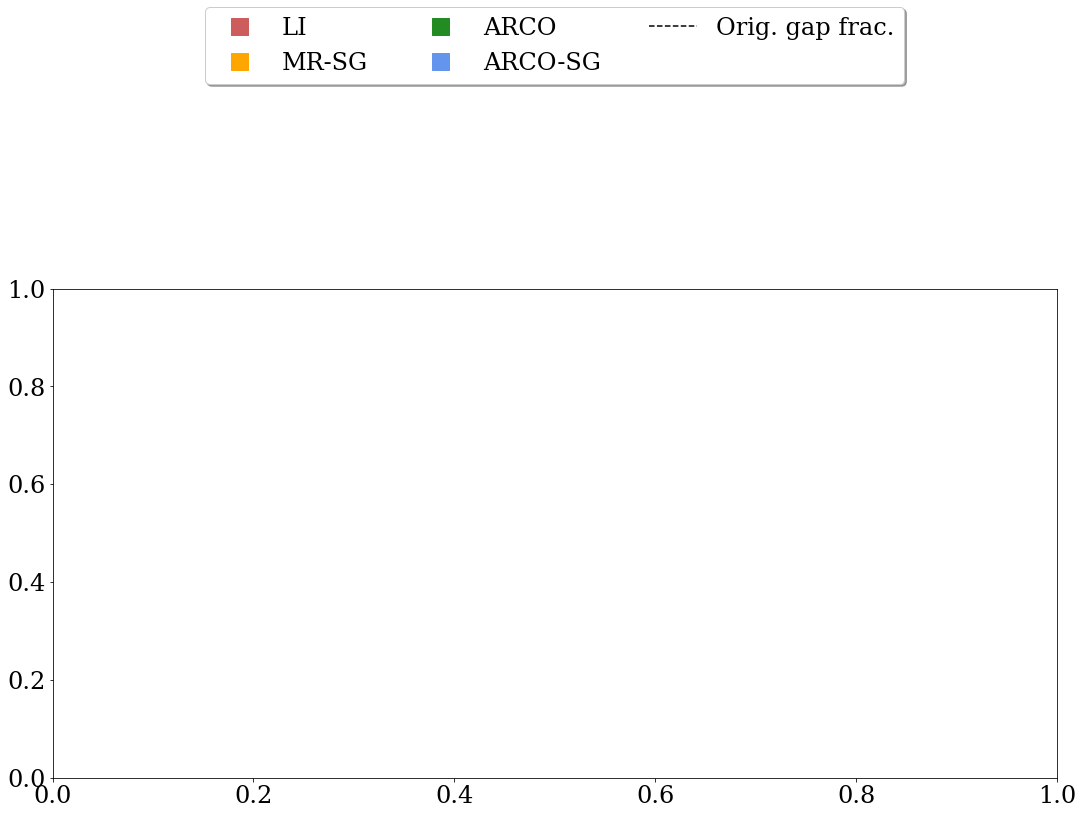

In [12]:
import matplotlib.lines as mlines
ms = 17
lw = 2.5
mw = 2
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(18,9))
LI = mlines.Line2D([], [], color='indianred', marker='s', linestyle='None',
                          markersize=ms, label='LI')
SWAG_SG = mlines.Line2D([], [], color='cornflowerblue', marker='s', linestyle='None',
                          markersize=ms, label='ARCO-SG')
ARCO = mlines.Line2D([], [], color='forestgreen', marker='s', linestyle='None',
                          markersize=ms, label='ARCO')
LI_SG = mlines.Line2D([], [], color='orange', marker='s', linestyle='None',
                          markersize=ms, label='MR-SG')

handles = [LI, LI_SG, ARCO, SWAG_SG]
handles.append(mlines.Line2D([], [], color='k', linestyle='--', label='Orig. gap frac.'))
    
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=3, fancybox=True, shadow=True)
# plt.savefig(f'legend.png', dpi=400, bbox_inches="tight")

plt.show()

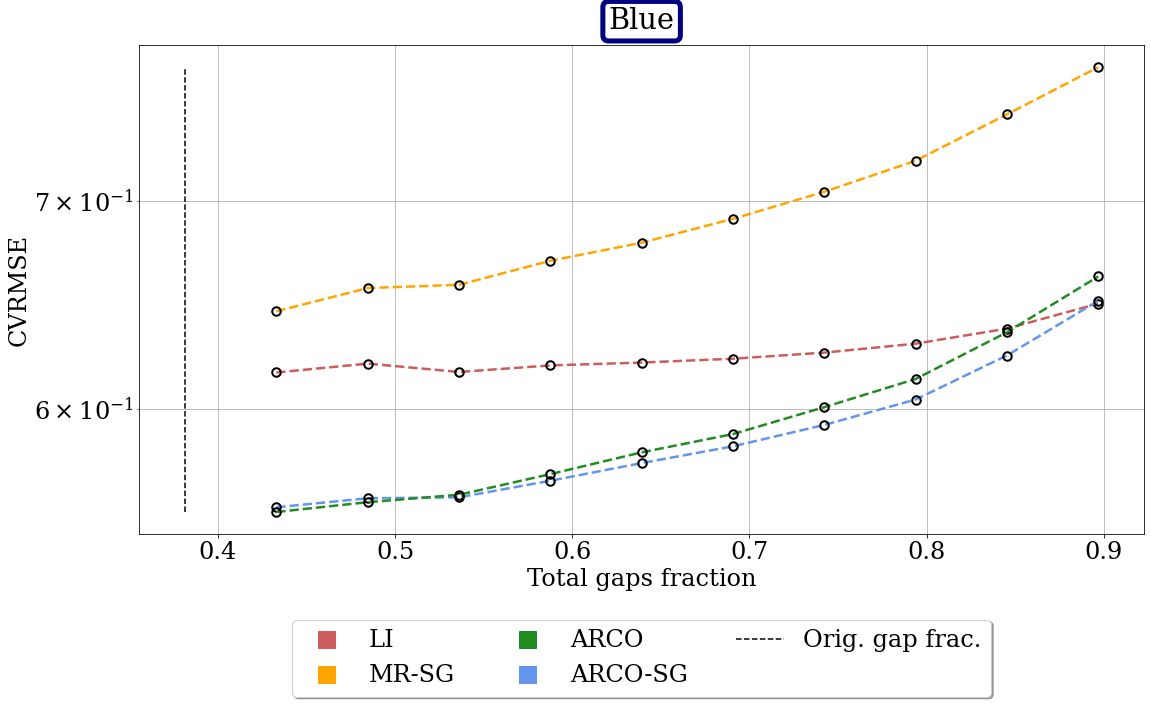

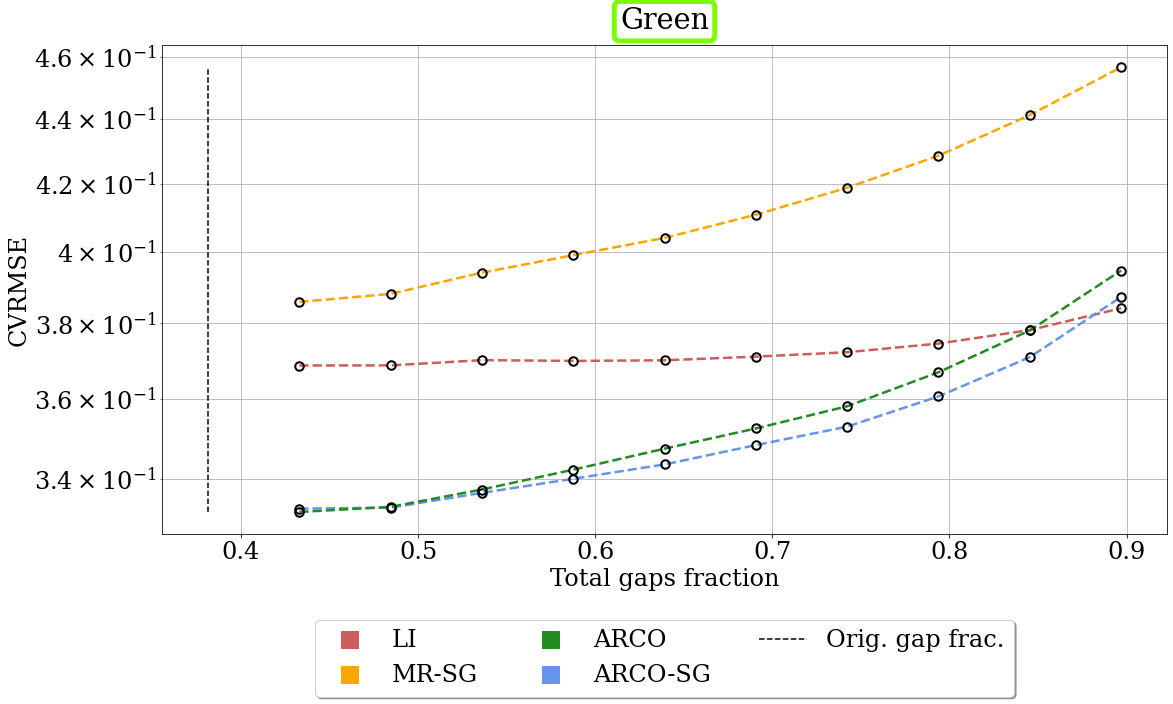

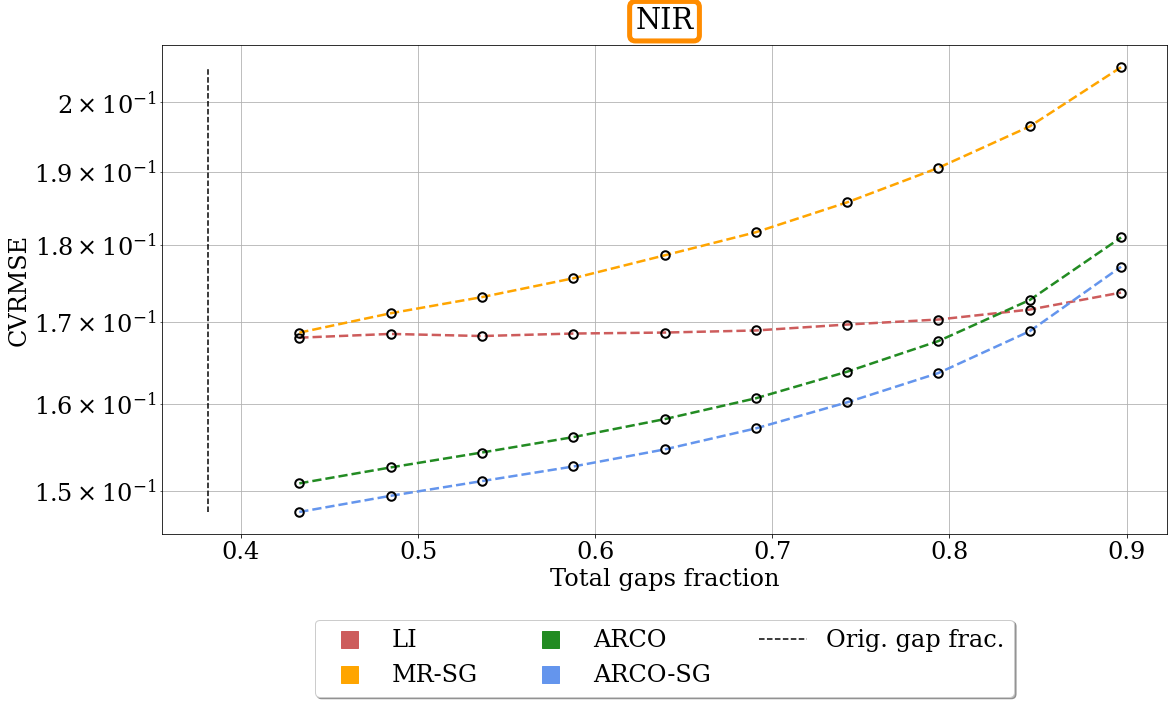

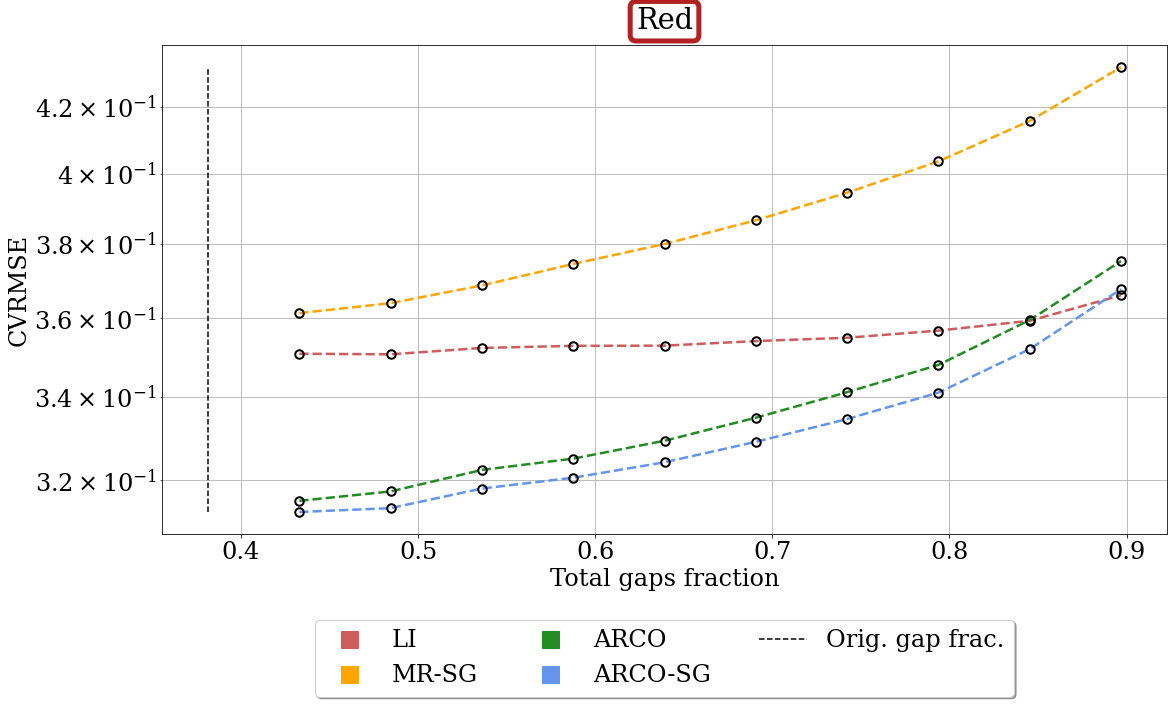

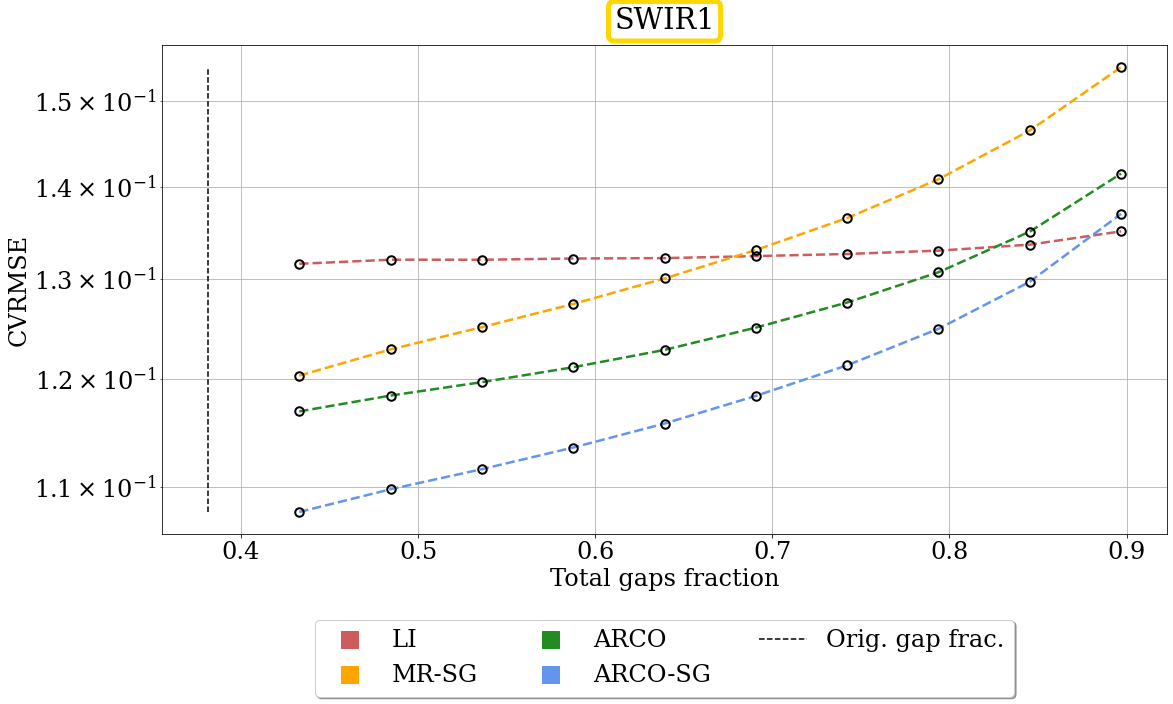

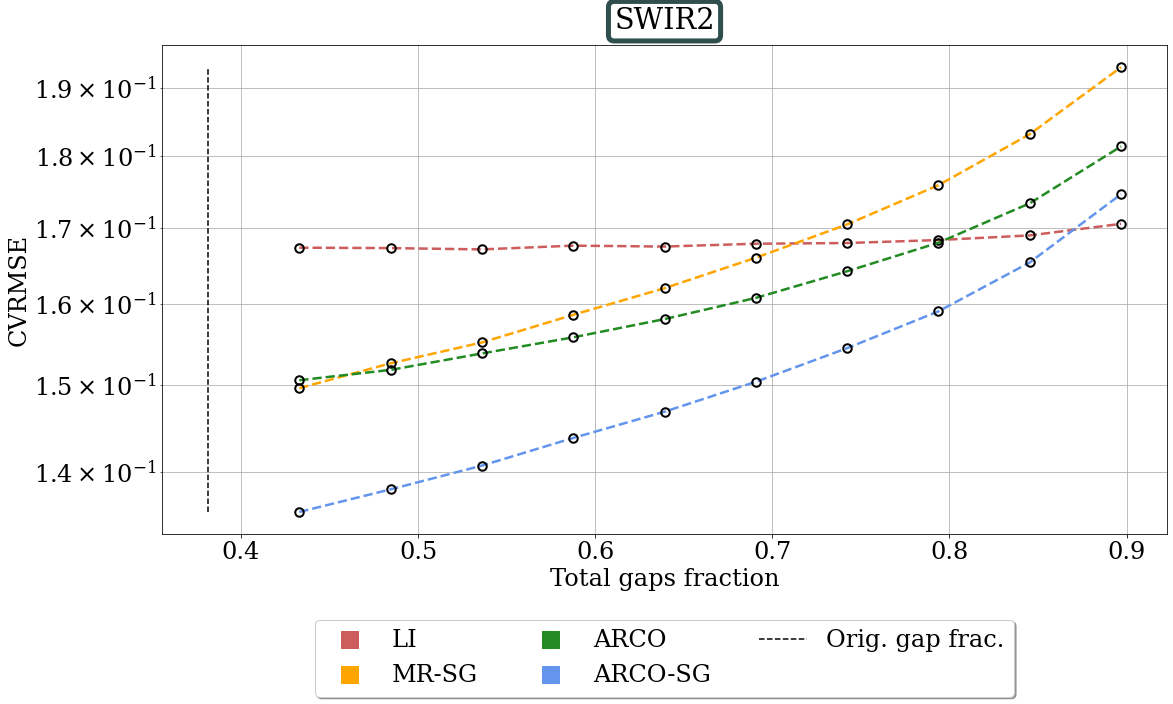

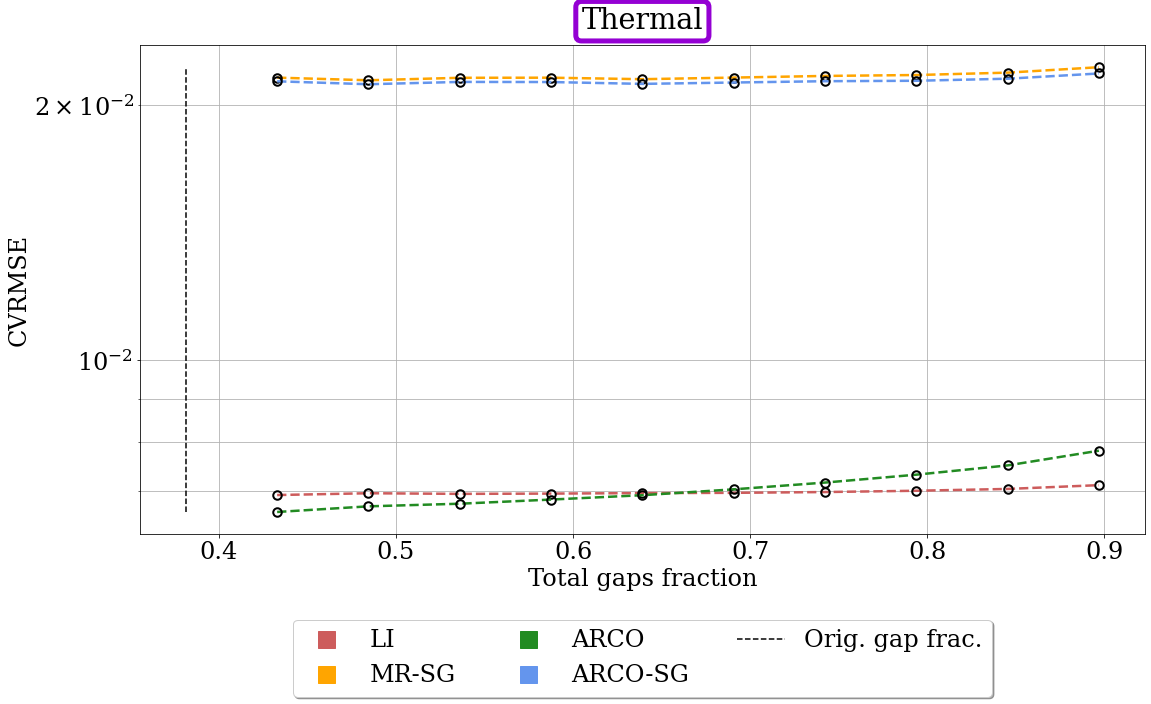

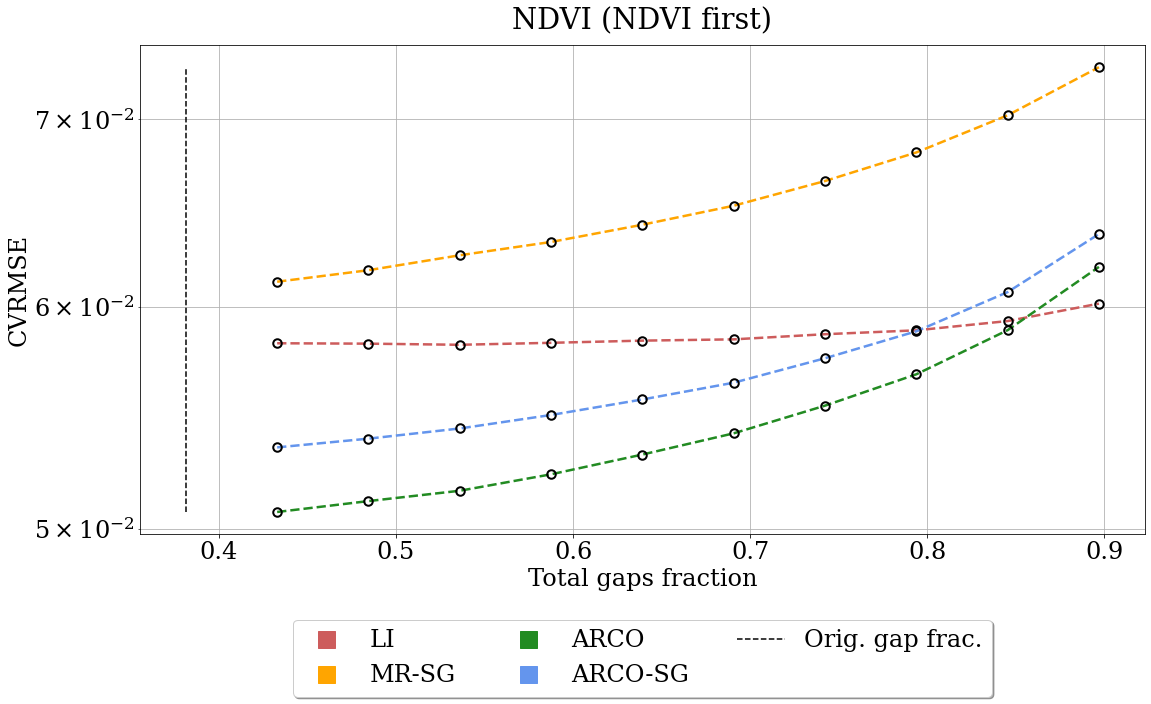

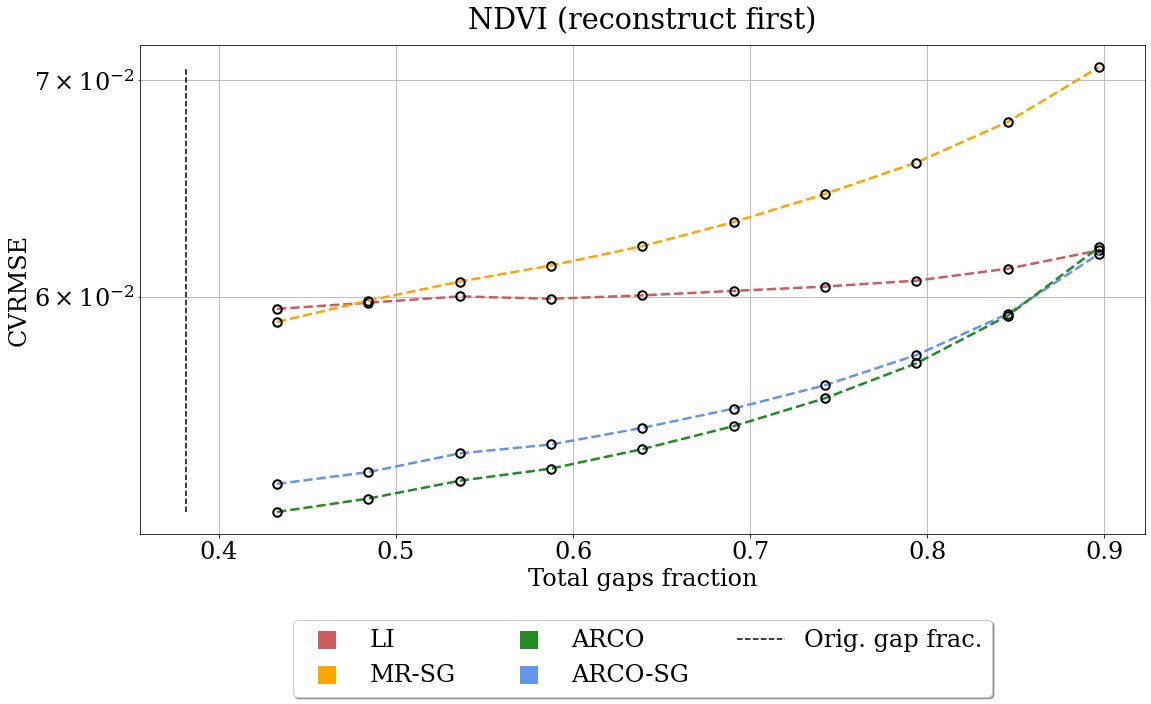

In [13]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
import matplotlib
orig_gap_fraq = np.sum(np.isnan(data_tmp).astype(int))/data_tmp.size
bands = ['Blue', 'Green', 'NIR', 'Red', 'SWIR1', 'SWIR2', 'Thermal', 'NDVI (NDVI first)', 'NDVI (reconstruct first)']
color_list = ['navy', 'lawngreen', 'darkorange', 'firebrick', 'gold', 'darkslategray', 'darkviolet', 'white', 'white']
ymin = 0.01
ymax = 1
ms = 17
lw = 2.5
mw = 2
for k in range(n_bands+2):
# for k in [n_bands]:
    band = bands[k]
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams.update({'font.size': 24})
    plt.figure(figsize=(18,9))

    plt.semilogy(tot_nan_fracs[:,k], CVRMSE_mat[:,0,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'indianred')
    plt.plot(tot_nan_fracs[:,k], CVRMSE_mat[:,1,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'orange')
    plt.plot(tot_nan_fracs[:,k], CVRMSE_mat[:,2,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'cornflowerblue')
    plt.plot(tot_nan_fracs[:,k], CVRMSE_mat[:,3,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'forestgreen')
    plt.vlines(orig_gap_fraq, np.min(CVRMSE_mat[:,:,k]), np.max(CVRMSE_mat[:,:,k]), colors='k', linestyles='--')
    plt.xlabel('Total gaps fraction')
    plt.ylabel('CVRMSE')
    plt.title(band, y=1.02,  bbox=dict(facecolor='none', linewidth=lw*2, edgecolor=color_list[k], boxstyle='round,pad=0.2'))
    plt.grid(True, which="both", ls="-")
    # plt.gca().yaxis.set_minor_formatter(ScalarFormatter());  
    # plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fancybox=True, shadow=True)
    plt.savefig(f'CVRMSE_{band}.png', dpi=400, bbox_inches="tight")
    plt.show()


## Histograms

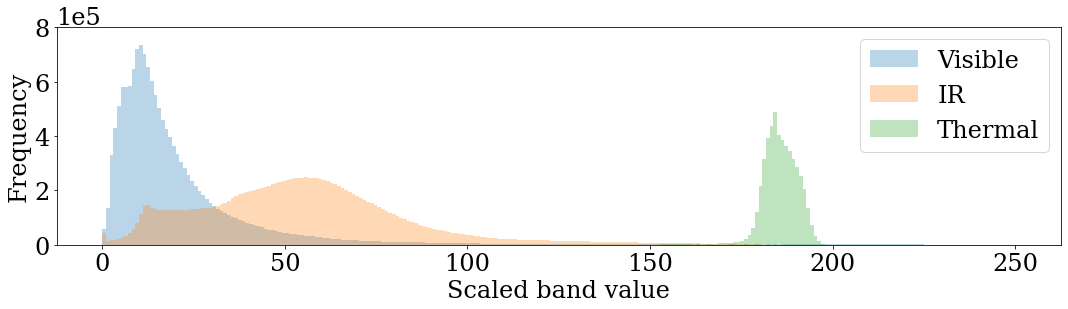

In [17]:
n_bands = 7
bands = ['Blue', 'Green', 'NIR', 'Red', 'SWIR 1', 'SWIR 2', 'Thermal']

idx_visible_0c = np.concatenate((np.arange(0*n_t_0c,(0+1)*n_t_0c), np.arange(1*n_t_0c,(1+1)*n_t_0c), np.arange(3*n_t_0c,(3+1)*n_t_0c)))
idx_IR_0c = np.concatenate((np.arange(2*n_t_0c,(2+1)*n_t_0c), np.arange(4*n_t_0c,(4+1)*n_t_0c), np.arange(5*n_t_0c,(5+1)*n_t_0c)))
idx_TIR_0c = np.arange(6*n_t_0c,(6+1)*n_t_0c)
idx_visible_1c = np.concatenate((np.arange(0*n_t_1c,(0+1)*n_t_1c), np.arange(1*n_t_1c,(1+1)*n_t_1c), np.arange(3*n_t_1c,(3+1)*n_t_1c)))
idx_IR_1c = np.concatenate((np.arange(2*n_t_1c,(2+1)*n_t_1c), np.arange(4*n_t_1c,(4+1)*n_t_1c), np.arange(5*n_t_1c,(5+1)*n_t_1c)))
idx_TIR_1c = np.arange(6*n_t_1c,(6+1)*n_t_1c)
idx_visible_ge2c = np.concatenate((np.arange(0*n_t_ge2c,(0+1)*n_t_ge2c), np.arange(1*n_t_ge2c,(1+1)*n_t_ge2c), np.arange(3*n_t_ge2c,(3+1)*n_t_ge2c)))
idx_IR_ge2c = np.concatenate((np.arange(2*n_t_ge2c,(2+1)*n_t_ge2c), np.arange(4*n_t_ge2c,(4+1)*n_t_ge2c), np.arange(5*n_t_ge2c,(5+1)*n_t_ge2c)))
idx_TIR_ge2c = np.arange(6*n_t_ge2c,(6+1)*n_t_ge2c)
data_visible = np.concatenate((merged_agg_data_1c[idx_visible_1c,:], \
                                   merged_agg_data_ge2c[idx_visible_ge2c,:], \
                                   merged_agg_data_0c[idx_visible_0c,:]), axis=0)
data_IR = np.concatenate((merged_agg_data_1c[idx_IR_1c,:], \
                                   merged_agg_data_ge2c[idx_IR_ge2c,:], \
                                   merged_agg_data_0c[idx_IR_0c,:]), axis=0)
data_TIR = np.concatenate((merged_agg_data_1c[idx_TIR_1c,:], \
                                   merged_agg_data_ge2c[idx_TIR_ge2c,:], \
                                   merged_agg_data_0c[idx_TIR_0c,:]), axis=0)

plt.figure(figsize=(18,4))
plt.hist(data_visible[~np.isnan(data_visible)], bins=np.linspace(0,250,250), label=f"Visible", histtype='stepfilled', alpha=0.3)
plt.hist(data_IR[~np.isnan(data_IR)], bins=np.linspace(0,250,250), label=f"IR", histtype='stepfilled', alpha=0.3)
plt.hist(data_TIR[~np.isnan(data_TIR)], bins=np.linspace(0,250,250), label=f"Thermal", histtype='stepfilled', alpha=0.3)


plt.legend()
plt.xlabel('Scaled band value')
plt.ylabel('Frequency')

plt.ylim(ymax=800000)
# plt.title(f"Stable LC")
plt.ticklabel_format(axis='y', style='sci', scilimits=(5,5))
plt.savefig('hist_SLC.png', dpi=400, bbox_inches="tight")

plt.show() 

# Compare original product

In [14]:
merged_ARCO_data_1c = np.load('merged_ARCO_data_1c.npy')
data_tmp = merged_agg_data_1c.copy()
n_t = data_tmp.shape[0]
n_s = data_tmp.shape[1]
data = np.zeros((1, n_t, n_s))
data[0,:,:] = data_tmp.copy()
wv_p_prod = get_SWAG_weights(46, 45, 6, n_s)[1:][::-1]
wv_f_prod = get_SWAG_weights(46, 45, 6, n_s)[1:]*0.0
sircleTransformer_prod = process.SircleTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="FFT", use_mask=True)
out_prod = sircleTransformer_prod._run(data)

# Stratified comparison

In [15]:
import pyreadr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs

In [16]:
strata = gpd.read_file('extracted_points_wgs84.gpkg')['Stratum'].to_numpy()
u_strata = np.unique(strata)
u_strata = np.delete(u_strata, 1, 0)

In [17]:
def add_nan_elements(A, fraction_of_nan):
    B = np.copy(A)
    non_nan_indices = np.where(~np.isnan(A))
    total_non_nan_elements = len(non_nan_indices[0])
    nan_elements_count = int(total_non_nan_elements * fraction_of_nan)
    chosen_indices = np.random.choice(total_non_nan_elements, nan_elements_count, replace=False)
    nan_indices = (non_nan_indices[0][chosen_indices], non_nan_indices[1][chosen_indices], non_nan_indices[2][chosen_indices])
    B[nan_indices] = np.nan
    return B

In [18]:
def compute_CCC(out_vec, data, data_ref):
    def concordance_correlation_coefficient(y_true, y_pred):
        import pandas as pd
        """Concordance correlation coefficient."""
        # Raw data
        dct = {
            'y_true': y_true,
            'y_pred': y_pred
        }
        df = pd.DataFrame(dct)
        # Remove NaNs
        df = df.dropna()
        # Pearson product-moment correlation coefficients
        y_true = df['y_true']
        y_pred = df['y_pred']
        cor = np.corrcoef(y_true, y_pred)[0][1]
        # Means
        mean_true = np.mean(y_true)
        mean_pred = np.mean(y_pred)
        # Population variances
        var_true = np.var(y_true)
        var_pred = np.var(y_pred)
        # Population standard deviations
        sd_true = np.std(y_true)
        sd_pred = np.std(y_pred)
        # Calculate CCC
        numerator = 2 * cor * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred)**2

        return numerator / denominator

    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        rerr.append(concordance_correlation_coefficient(data_ref[mask_cmp], out_i[mask_cmp]))
    return rerr

In [19]:
def compute_CVRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        mean_ref = np.mean(np.array(data_ref[mask_cmp], dtype=np.double))
        CVRMSE = RMSE / mean_ref
        rerr.append(CVRMSE)
    return rerr

In [20]:
def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

In [21]:
bands = ['blue', 'green', 'nir', 'red', 'swir1', 'swir2', 'thermal']

n_strata = len(u_strata)

CVRMSE_mat = np.zeros((7,n_strata))
CCC_mat = np.zeros((7,n_strata))
CVRMSE_mat_SG = np.zeros((7,n_strata))
CCC_mat_SG = np.zeros((7,n_strata))
tot_nan_fracs = np.zeros((n_strata,))

nan_fraction = 0.1
clear_mat = pyreadr.read_r('clear.rds')[None].to_numpy()
for i, band in enumerate(bands):
    band_mat = pyreadr.read_r(f'{band}.rds')[None].to_numpy()
    print(f"Band {band}")
    print(f"Stratum: ", end="")
    for j, stratum in enumerate(u_strata):
        print(f"{stratum}, ", end="")
        if stratum == 1:
            agg_nogap_mask_1 = (clear_mat[strata==1,:] == 250)    
            data_tmp_1 = band_mat[strata==1,:]
            n_t = data_tmp_1.shape[0]
            n_s = data_tmp_1.shape[1]
            agg_nogap_mask_2 = (clear_mat[strata==2,:] == 250)    
            data_tmp_2 = band_mat[strata==2,:]
            agg_nogap_mask = np.zeros((n_t, n_s), bool)
            data_tmp = np.zeros((n_t, n_s), np.double)
            cut = int(n_t*0.97)
            agg_nogap_mask[0:cut,:] = agg_nogap_mask_1[0:cut,:]
            agg_nogap_mask[cut:,:] = agg_nogap_mask_2[0:n_t-cut,:]
            data_tmp[0:cut,:] = data_tmp_1[0:cut,:]
            data_tmp[cut:,:] = data_tmp_2[0:n_t-cut,:]
        else:
            agg_nogap_mask = (clear_mat[strata==stratum,:] == 250)    
            data_tmp = band_mat[strata==stratum,:]            
        data_tmp[~agg_nogap_mask] = np.nan
        n_t = data_tmp.shape[0]
        n_s = data_tmp.shape[1]
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()
        data = add_nan_elements(data_ref, nan_fraction)
        tot_nan_fracs[j] = np.sum(np.isnan(data).astype(int))/data.size

        wv_p_prod = get_SWAG_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWAG_weights(46, 45, 6, n_s)[1:]*0.0
        sircleTransformer_prod = process.SircleTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True)
        out_prod = sircleTransformer_prod._run(data)
        
        CCC_mat[i,j] = compute_CCC((out_prod,), data, data_ref)[0]
        CVRMSE_mat[i,j] = compute_CVRMSE((out_prod,), data, data_ref)[0]
    print(f" ")

    
    


Band blue
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band green
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band nir
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band red
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir1
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir2
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band thermal
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  


## Legend of ESA-CCI at https://maps.elie.ucl.ac.be/CCI/viewer/download/CCI-LC_Maps_Legend.pdf

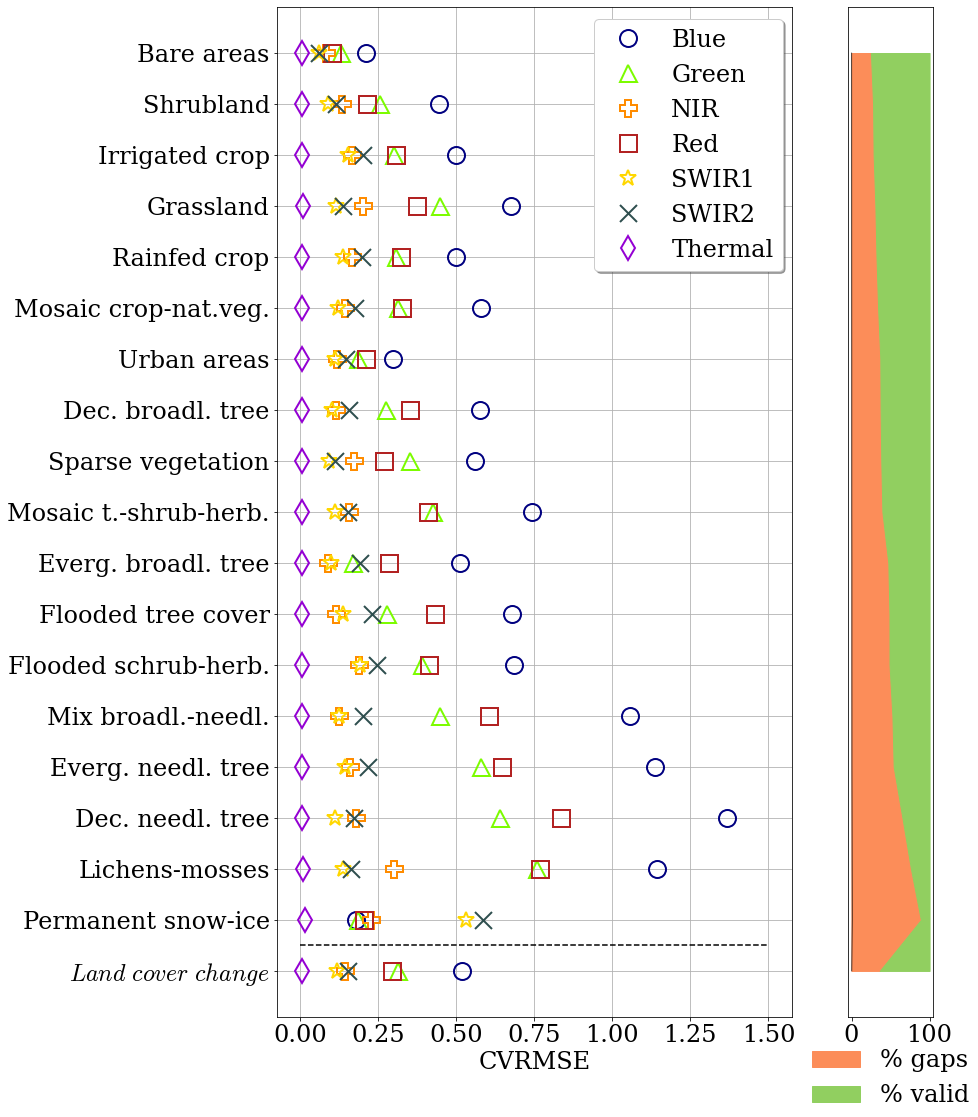

In [22]:
import matplotlib.lines as mlines
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(14,16))
grid = plt.GridSpec(1, 2, width_ratios=[6, 1])
ax1 = plt.subplot(grid[0])
ax2 = plt.subplot(grid[1])
order = np.argsort(tot_nan_fracs)[::-1]
range_arr = np.arange(order.size)  
tmp = order[np.where(order==0)[0][0]]
order[range_arr != 0 ] = order[range_arr != np.where(order==0)[0][0]]
order[0] = tmp
ms = 17
mw = 2
bands = ['Blue', 'Green', 'NIR', 'Red', 'SWIR1', 'SWIR2', 'Thermal']
marker_list = ['o', '^', 'P', 's', '*', 'x', 'd']
color_list = ['navy', 'lawngreen', 'darkorange', 'firebrick', 'gold', 'darkslategray', 'darkviolet']
# ticks = ['1','2','10','20','30','50','60','70','80','90','100','120','130','140','150','160','180','190','200','220']
ticks_orig = ['$\mathregular{\mathit{Land \  cover \  change}}$','Rainfed crop','Irrigated crop','Mosaic crop-nat.veg.','Everg. broadl. tree','Dec. broadl. tree','Everg. needl. tree','Dec. needl. tree', \
         'Mix broadl.-needl.','Mosaic t.-shrub-herb.','Shrubland','Grassland','Lichens-mosses','Sparse vegetation','Flooded tree cover','Flooded schrub-herb.','Urban areas','Bare areas','Permanent snow-ice']
handles = []
ticks = []

for i, band in enumerate(bands):
    handles.append(mlines.Line2D([], [], color=color_list[i], marker=marker_list[i], linestyle='None', markeredgewidth=mw, 
                          markersize=ms,  mfc='none', label=bands[i]))
    for k, j in enumerate(order):
        if i == 0:
            ticks.append(ticks_orig[j])
        ax1.plot(CVRMSE_mat[i,j], k, marker=marker_list[i],  markersize=ms,  mfc='none', color=color_list[i], markeredgewidth=mw)
ax1.set_xlabel('CVRMSE')
ax1.hlines(0.5,0,1.5,'k',linestyles='dashed')
ax1.set_yticks(range(n_strata), ticks, fontdict=None, minor=False)
ax1.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.80, 1),
          ncol=1, fancybox=True, shadow=True)
ax1.grid()
plt.subplot(1, 2, 2)
n = len(tot_nan_fracs[order])
ax2.plot(tot_nan_fracs[order], range(n), color='k', linewidth=0.7)
ax2.fill_betweenx(range(n), tot_nan_fracs[order]*100, 0.0, color='#fc8d59',  label='% gaps')
ax2.fill_betweenx(range(n), tot_nan_fracs[order]*100, 100, color='#91cf60', label='% valid')
ax2.set_yticks([])
ax2.hlines(0.5,0,1,'k',linestyles='dashed')
ax2.set_xlabel('Gaps')
leg = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.018), ncol=1, fancybox=False, shadow=False, borderpad=0.1)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(None)
plt.tight_layout()
plt.savefig('ESACCI_CVRMSE.png', dpi=400, bbox_inches="tight")
plt.show()